# Classifying Images using Dropout and Batchnorm Layer

## Introduction

In this notebook, you learn how to build a neural network to classify the tf-flowers dataset using dropout and batchnorm layer.

## Learning objectives

* Define Helper Functions.
* Apply dropout and batchnorm layer.


Each learning objective will correspond to a __#TODO__ in the student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solutions/classifying_images_using_dropout_and_batchnorm_layer.ipynb).


In [1]:
import tensorflow as tf
print(tf.version.VERSION)

2024-07-12 16:53:42.428844: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-12 16:53:42.713202: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-12 16:53:43.747153: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-12 16:53:45.876368: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1


## Define Helper Functions
#### Reading and Preprocessing image data

In [2]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(filename):
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);

In [3]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)

  # Resize the image to the desired size.
  # TODO 1 -- Your code here
  return tf.image.resize(img,reshape_dims)

CLASS_NAMES = [item.numpy().decode("utf-8") for item in 
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*"),
                 "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

# the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

2024-07-12 16:54:31.298505: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Apply dropout and batchnorm layer
A deep neural network (DNN) is a neural network with more than one hidden layer. Each time you add a layer, the number of trainable parameters increases. Therefore,you need a larger dataset. You still have only 3700 flower images which might cause overfitting.


Dropouts are the regularization technique that is used to prevent overfitting in the model. Batch normalization is a layer that allows every layer of the network to do learning more independently. The layer is added to the sequential model to standardize the input or the outputs. Add a dropout and batchnorm layer after each of the hidden layers.

#### Dropout
Dropout is one of the oldest regularization techniques in deep learning. At each training iteration, it drops random neurons from the network with a probability p (typically 25% to 50%). In practice, neuron outputs are set to 0. The net result is that these neurons will not participate in the loss computation this time around and they will not get weight updates. Different neurons will be dropped at each training iteration.
#### Batch normalization
Our input pixel values are in the range [0,1] and this is compatible with the dynamic range of the typical activation functions and optimizers. However, once we add a hidden layer, the resulting output values will no longer lie in the dynamic range of the activation function for subsequent layers. When this happens, the neuron output is zero, and because there is no difference by moving a small amount in either direction, the gradient is zero. There is no way for the network to escape from the dead zone. To fix this, batch norm normalizes neuron outputs across a training batch of data, i.e. it subtracts the average and divides by the standard deviation. This way, the network decides, through machine learning, how much centering and re-scaling to apply at each neuron. In Keras, you can selectively use one or the other:

`tf.keras.layers.BatchNormalization(scale=False, center=True)`

When using batch normalization, remember that:
1. Batch normalization goes between the output of a layer and its activation function. So, rather than set activation='relu' in the Dense layer’s constructor, we’d omit the activation function, and then add a separate Activation layer.
2. If you use center=True in batch norm, you do not need biases in your layer. The batch norm offset plays the role of a bias.
3. If you use an activation function that is scale-invariant (i.e. does not change shape if you zoom in on it) then you can set scale=False. ReLu is scale-invariant. Sigmoid is not.

In [4]:
def train_and_evaluate(batch_size = 32,
                       lrate = 0.0001,
                       l1 = 0,
                       l2 = 0.001,
                       dropout_prob = 0.4,
                       num_hidden = [64, 16]):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      "/opt/repo/training-data-analyst/courses/machine_learning/data/flowers/train_set.csv").
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      "/opt/repo/training-data-analyst/courses/machine_learning/data/flowers/eval_set.csv").
      map(decode_csv)).batch(32) # this doesn't matter

  # NN with multiple hidden layers
  layers = [tf.keras.layers.Flatten(
      input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
      name='input_pixels')]
  for hno, nodes in enumerate(num_hidden):
    layers.extend([
      tf.keras.layers.Dense(nodes,
                            kernel_regularizer=regularizer, 
                            name='hidden_dense_{}'.format(hno)),
      tf.keras.layers.BatchNormalization(scale=False, # ReLU
                                         center=False, # have bias in Dense
                                         name='batchnorm_dense_{}'.format(hno)),
      #move activation to come after batchnorm
      tf.keras.layers.Activation('relu', name='relu_dense_{}'.format(hno)),
      tf.keras.layers.Dropout(rate=dropout_prob, name='dropout_dense_{}'.format(hno))
    ])  
  # TODO 2 -- Your code here

  layers.append(
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
  )

  model = tf.keras.Sequential(layers, name='flower_classification')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

/home/osboxes/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "flower_classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_pixels (Flatten)          │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_dense_0 (Dense)          │ (None, 64)             │     9,633,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_dense_0               │ (None, 64)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_dense_0 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense_0 (Dropout)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_dense_1 (Dense)          │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm_dense_1               │ (None, 16)             │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu_dense_1 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_dense_1 (Dropout)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flower_prob (Dense)             │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,635,141 (36.76 MB)

 Trainable params: 9,634,981 (36.75 MB)

 Non-trainable params: 160 (640.00 B)

None
Epoch 1/10
    104/Unknown 20s 173ms/step - accuracy: 0.2578 - loss: 2.0194

2024-07-12 17:01:27.102505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/osboxes/anaconda3/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


104/104 ━━━━━━━━━━━━━━━━━━━━ 21s 182ms/step - accuracy: 0.2579 - loss: 2.0188 - val_accuracy: 0.3703 - val_loss: 1.7225
Epoch 2/10


2024-07-12 17:01:28.024943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.3113 - loss: 1.8082

2024-07-12 17:01:45.284259: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


104/104 ━━━━━━━━━━━━━━━━━━━━ 18s 170ms/step - accuracy: 0.3114 - loss: 1.8079 - val_accuracy: 0.2378 - val_loss: 2.1715
Epoch 3/10


2024-07-12 17:01:45.789735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.3578 - loss: 1.6993

2024-07-12 17:02:05.180237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


104/104 ━━━━━━━━━━━━━━━━━━━━ 20s 165ms/step - accuracy: 0.3578 - loss: 1.6993 - val_accuracy: 0.3297 - val_loss: 1.6901
Epoch 4/10


2024-07-12 17:02:05.729468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.3743 - loss: 1.6211

2024-07-12 17:02:23.068488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


104/104 ━━━━━━━━━━━━━━━━━━━━ 18s 171ms/step - accuracy: 0.3743 - loss: 1.6211 - val_accuracy: 0.2514 - val_loss: 1.9228
Epoch 5/10


2024-07-12 17:02:23.595618: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.3963 - loss: 1.6098

2024-07-12 17:02:41.501978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-12 17:02:41.963161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


104/104 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.3963 - loss: 1.6097 - val_accuracy: 0.4135 - val_loss: 1.5535
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.4333 - loss: 1.5215

2024-07-12 17:02:57.750628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


104/104 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 0.4331 - loss: 1.5217 - val_accuracy: 0.3838 - val_loss: 1.5674
Epoch 7/10


2024-07-12 17:02:58.228267: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.4210 - loss: 1.5391

2024-07-12 17:03:19.154083: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


104/104 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - accuracy: 0.4211 - loss: 1.5390 - val_accuracy: 0.4054 - val_loss: 1.5394
Epoch 8/10


2024-07-12 17:03:19.687996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.4465 - loss: 1.4883

2024-07-12 17:03:36.407332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


104/104 ━━━━━━━━━━━━━━━━━━━━ 17s 165ms/step - accuracy: 0.4464 - loss: 1.4884 - val_accuracy: 0.4270 - val_loss: 1.5267
Epoch 9/10


2024-07-12 17:03:36.919002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.4334 - loss: 1.4791

2024-07-12 17:03:57.135356: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


104/104 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - accuracy: 0.4334 - loss: 1.4791 - val_accuracy: 0.4162 - val_loss: 1.5601
Epoch 10/10


2024-07-12 17:03:57.649607: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.4490 - loss: 1.4683

2024-07-12 17:04:17.336980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


104/104 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - accuracy: 0.4490 - loss: 1.4682 - val_accuracy: 0.4216 - val_loss: 1.6196


2024-07-12 17:04:17.841285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


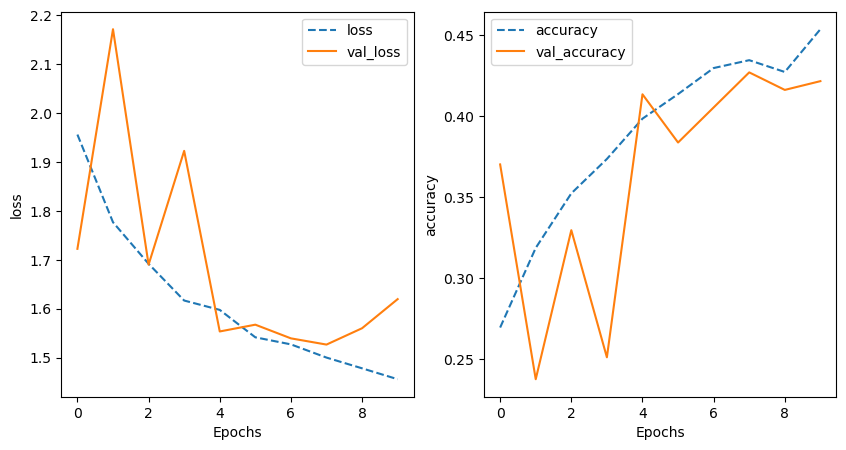

In [5]:
model = train_and_evaluate(dropout_prob=0.4)

Congrats! You've completed the lab!